In [74]:
import numpy as np
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

## Load Dataset labeled with hate speech

In [75]:
df = pd.read_csv('../data/hate_add.csv')
df = df[(df['racism']=='racism') | (df['racism']=='sexism')]

In [76]:
df.head()

,572342978255048705,racism
0,572341498827522049,racism
1,572340476503724032,racism
2,572334712804384768,racism
3,572332655397629952,racism
4,575949086055997440,racism


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5347 entries, 0 to 5346
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   572342978255048705  5347 non-null   int64 
 1   racism              5347 non-null   object
dtypes: int64(1), object(1)
memory usage: 125.3+ KB


In [78]:
df.racism.value_counts()

sexism    3378
racism    1969
Name: racism, dtype: int64

In [79]:
df.columns = ['id','label']

In [80]:
def group_list(l,size = 100):
    """
    Generate batches of 100 ids in each
    Returns list of strings with , seperated ids
    """
    n_l =[]
    idx = 0
    while idx < len(l):        
        n_l.append(
            ','.join([str(i) for i in l[idx:idx+size]])
        )
        idx += size
    return n_l

In [81]:
def tweets_request(tweets_ids):
    
    """
    Make a requests to Tweeter API
    """
    
    df_lst = []
    
    for batch in tweets_ids:
        url = "https://api.twitter.com/2/tweets?ids={}&tweet.fields=created_at&expansions=author_id&user.fields=created_at".format(batch)
        payload={}
        headers = {'Authorization': 'Bearer ',
        'Cookie': 'personalization_id="v1_hzpv7qXpjB6CteyAHDWYQQ=="; guest_id=v1%3A161498381400435837'}
        r = requests.request("GET", url, headers=headers, data=payload)
        data = r.json()
        if 'data' in data.keys():
            df_lst.append(pd.DataFrame(data['data']))
    
    return pd.concat(df_lst)

##  Getting actual tweets text with API requests

In [82]:
racism_sex_hate_id = group_list(list(df.id))

In [83]:
# df_rac_sex_hate = tweets_request(racism_sex_hate_id)

In [84]:
df_rac_sex_hate = pd.read_csv('../data/df_ras_sex_hate.csv')

In [85]:
df_rac_sex_hate.head()

,Unnamed: 0,id,author_id,created_at,text
0,0,5.723415e+17,1.101148e+08,2015-03-02T10:23:41.000Z,Drasko they didn't cook half a bird you idiot ...
1,1,5.723405e+17,3.865021e+07,2015-03-02T10:19:37.000Z,Hopefully someone cooks Drasko in the next ep ...
2,2,5.723347e+17,2.587278e+09,2015-03-02T09:56:43.000Z,of course you were born in serbia...you're as ...
3,3,5.723327e+17,2.601525e+09,2015-03-02T09:48:33.000Z,These girls are the equivalent of the irritati...
4,0,4.464610e+17,9.306205e+08,2014-03-20T01:39:29.000Z,RT @YesYoureRacist: At least you're only a tin...


In [86]:
df_rac_sex_hate = df_rac_sex_hate.drop(columns=['Unnamed: 0', 'id', 'author_id', 'created_at'])

In [87]:
df_rac_sex_hate['class'] = 1

In [88]:
df_rac_sex_hate.head()

,text,class
0,Drasko they didn't cook half a bird you idiot ...,1
1,Hopefully someone cooks Drasko in the next ep ...,1
2,of course you were born in serbia...you're as ...,1
3,These girls are the equivalent of the irritati...,1
4,RT @YesYoureRacist: At least you're only a tin...,1


In [89]:
df_rac_sex_hate.shape

(2744, 2)

## Loading second Labeled Dataset with twits

In [90]:
df_l = pd.read_csv("../data/labeled_data.csv")
df_l.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


1    0.774321
2    0.167978
0    0.057701
Name: class, dtype: float64


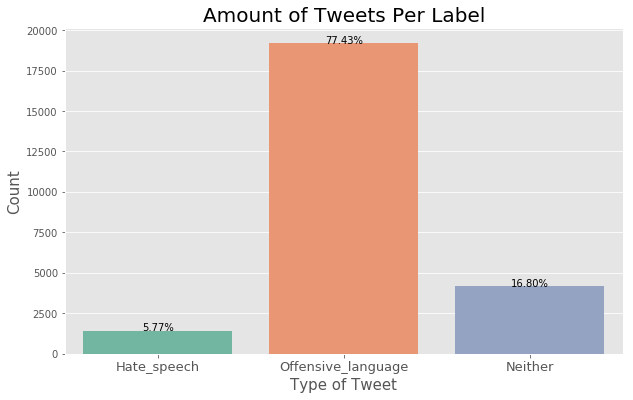

In [93]:
print(df_l['class'].value_counts(normalize=True))

# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(df_l['class'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Hate_speech','Offensive_language', 'Neither'],fontsize = 13)

total = float(len(df_l)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center")


In [94]:
# class 0 - hate tweets
# class 1 - offensive_language tweets
# class 2 - neither tweets

In [95]:
df_l['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

## Lets combine Offensive_language and Neither and mark it as not_hate_speech

In [96]:
df_hate_not_hate = df_l.copy()
df_hate_not_hate['class'] = df_hate_not_hate['class'].map(lambda x : 1 if x == 0 else 0)

In [97]:
df_hate_not_hate['class'].value_counts()

0    23353
1     1430
Name: class, dtype: int64

0    0.942299
1    0.057701
Name: class, dtype: float64


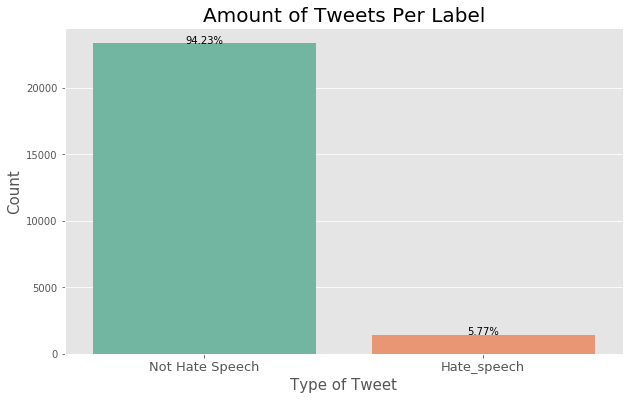

In [98]:
print(df_hate_not_hate['class'].value_counts(normalize=True))

# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(df_hate_not_hate['class'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate_speech'],fontsize = 13)

total = float(len(df_l)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center")
plt.savefig('../images/class_inbal.png')

In [99]:
# considering only class 0 (hate tweets) and class 2 (neither tweets) as binary classification problem
# updating neither tweets as not hate speech

In [100]:
df_l = df_l.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])

In [101]:
df_l = df_l[(df_l['class']==0) | (df_l['class']==2)]

In [102]:
df_l['class'] = df_l['class'].map(lambda x : 0 if x == 2 else 1)

In [103]:
df_l.rename(columns={'tweet':'text'}, inplace= True)

## Lets combine 2 Data Frames with Labeled Classes of hate speach and not hate speach

In [104]:
df_combined = pd.concat([df_rac_sex_hate,df_l])

1    0.50066
0    0.49934
Name: class, dtype: float64


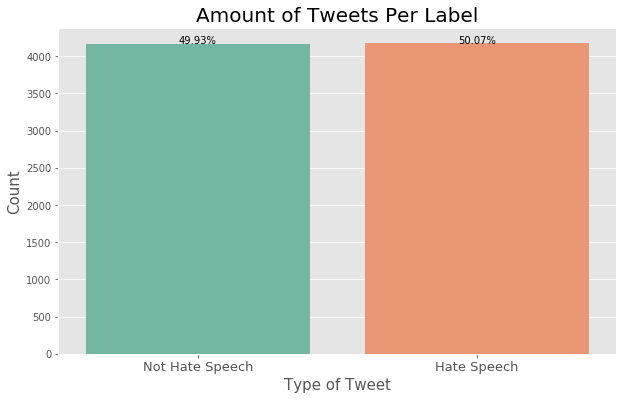

In [105]:
print(df_combined['class'].value_counts(normalize=True))

# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(df_combined['class'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate Speech'],fontsize = 13)

total = float(len(df_combined)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 
    
plt.savefig('../images/class_balan.png')

### Saving combined Data to CSV file 

In [106]:
df_combined.to_csv('../data/balanced_data_combined.csv')